## Reference:

Ye, H. (2019). Accurate image reconstruction in radio interferometry (Doctoral thesis). https://doi.org/10.17863/CAM.39448

Haoyang Ye, Stephen F Gull, Sze M Tan, Bojan Nikolic, Optimal gridding and degridding in radio interferometry imaging, Monthly Notices of the Royal Astronomical Society, Volume 491, Issue 1, January 2020, Pages 1146–1159, https://doi.org/10.1093/mnras/stz2970

Github: https://github.com/zoeye859/Imaging-Tutorial

In [124]:
%matplotlib notebook
import numpy as np
from scipy.optimize import leastsq, brent
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from time import process_time
from numpy.linalg import inv
np.set_printoptions(precision=16)

### 1. Read in the data

In [133]:
#########  Read in visibilities ##########
data = np.genfromtxt('simul3d.csv', delimiter = ',')
jj = complex(0,1)
u = data.T[2][1:]
v = data.T[3][1:]
w = data.T[4][1:]
V = data.T[5][1:] + jj*data.T[6][1:]
n_uv = len(u)
uv_max = max(np.sqrt(u**2+v**2))
print (w.max(), w.min())

41.780796 -41.090683


In [134]:
print (V)

[ -3.585633 -5.350139j   1.684217 +9.527432j   1.917094 -6.619909j ...
 -11.496424+11.6156j     1.737725 +7.722598j   3.254815 +7.631811j]


In [126]:
for i in range(n_uv):
    if w[i] < 0:
        u[i] = -u[i]
        v[i] = -v[i]
        w[i] = -w[i]
        V[i] = np.conjugate(V[i])

In [127]:
#### Determine the pixel size ####

X_size = 300 # image size on x-axis
Y_size = 300 # image size on y-axis
X_min = -1.15/2 #You can change X_min and X_max in order to change the pixel size.
X_max = 1.15/2
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -1.15/2 #You can change Y_min and Y_max in order to change the pixel size.
Y_max = 1.15/2
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]
pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

The pixel size on x-axis is  790.681757280536  arcsec


### 2. determine the number of w planes 

Here is a short introduction to the original W-Stacking method (Offringa, 2014). Starting from 

$V(u,v,w) = \int\int \frac{\text{d}l \text{d}m }{\sqrt{1-l^2-m^2}}I(l,m)\exp\left[-i2\pi\left(ul+vm+w\left(\sqrt{1-l^2-m^2}-1\right)\right)\right]	$

The right-hand side can be separated into one part without any $w$-term and the rest which contains the $w$-term. For each given non--zero $w_i$, we have

$V(u,v,w_i) = \int \int \mathrm{d}l \mathrm{d}m \frac{I(l,m)}{\sqrt{1-l^2-m^2}} \exp{[-i2\pi(ul+vm)]}\exp{\Big\{-i2\pi\Big[w_i\Big(\sqrt{1-l^2-m^2}-1\Big)\Big]}\Big\}$

For each given non-zero $w_i$, this is essentially a two--dimensional Fourier transform. By inverting the transform, we have:

$\frac{I(l,m)}{\sqrt{1-l^2-m^2}} = \int \int \mathrm{d}u \mathrm{d}v V(u,v,w_i)\exp{[i2\pi(ul+vm)]}	\exp{\Big\{i2\pi\Big[w_i\Big(\sqrt{1-l^2-m^2}-1\Big)\Big]}\Big\} $

If we integrate both sides along the $w$-axis from the minimum $w_{\rm min}$ to the maximum $w_{\rm max}$ on the right-hand side, the result is

$\frac{I(l,m)(w_{\rm max} - w_{\rm min})}{\sqrt{1-l^2-m^2}} = \int_{w_{\rm min}}^{w_{\rm max}} \mathrm{d}w \exp{\Big\{\mathrm{i}2\pi\Big[w\Big(\sqrt{1-l^2-m^2}-1\Big)\Big]}\Big\}$
$\int \int \mathrm{d}u \mathrm{d}v V(u,v,w)\exp{[i2\pi(ul+vm)]}$

In practice, the values of $w$ are discretised into $N_w$ uniform samples along the $w$-axis,  can be written as:

$\frac{I(l,m)(w_{\rm max} - w_{\rm min})}{\sqrt{1-l^2-m^2}} = \sum_{n = 0}^{N_w-1}\exp{\Big\{i2\pi\Big[w_n\Big(\sqrt{1-l^2-m^2}-1\Big)\Big]}\Big\}\int \int \mathrm{d}u \mathrm{d}v V(u,v,w_n)\exp{[i2\pi(ul+vm)]} $

Following (Offringa, 2014), the separation of two subsequent $w$ values $\delta w$ should satisfy the criterion:

$|\delta w 2\pi(\sqrt{1-l^2-m^2}-1)| \ll 1$

If $\delta w$ is larger than this, more $w$ samples are needed. Hence, $N_w$ is determined by:

$N_w \geq 2\pi(w_{\rm max} - w_{\rm min})\max_{l,m}(1-\sqrt{1-l^2-m^2})$



### 2.1 Redetermin the number of w planes

<img src="normalised_coordinate.png">

In the normalised coordinate system plotted above, the field of view is confined in the region of $[-0.5,0.5]$. $x_0$ and $y_0$ represents how much of the image will be cropped after the FFT process （Ye,2019 on optimal gridding and degridding）. Here we have $x_0 = y_0$. The angular size of the map required for the FFT in $l$ is $l_{\rm range}/(2x_0)$, and is $N_x$ pixels. If $u$ is specified in wavelengths, it is multiplied by $l_{\rm range}/(2x_0)$ to convert to pixels, so that we redetermin the number of $w$-planes as:

$N_x \geq (u_{\rm max}-u_{\rm min})l_{\rm range}/x_0$

We now consider the choice of the $w$ or $z$ grid. We set the phase centre $z=0$ at $n=0$ and $z=-x_0$ at $n_{\rm min}$. In our improved W-Stacking, we do not apply FFT in the $z$ direction, so there is no advantage in oversampling the beam considerably. Consequently,

$N_z \geq (w_{\rm max}-w_{\rm min})n_{\rm min}/x_0$

The number of $w$-planes using least-misfit gridding function can therefore be determined as:

$N_{w'} \equiv N_z \geq\frac{\max_{l,m}(1-\sqrt{1-l^2-m^2})(w_{\rm max} - w_{\rm min})}{x_0} + W$

The additional $w$-planes enable visibilities located close to the top or bottom $w$-planes to be gridded to grids on both sides.

The number of $w$-planes, $N_{w}$, determined by the original W-Stacking method is more than 1.5 times greater than the first part of $N_{w'}$. Thus, for given data, the improved W-Stacking method may require fewer $w$--planes than the original W-Stacking method. $x_0 = 0.25, W\geq 7$ is recommended so as to achieve the single precision limit in the image misfit level.



### w plane number N_w


In [129]:
x0=0.25
N_w = int(np.ceil((1-np.sqrt(1-(X_max)**2-(Y_max)**2))*(np.max(w)-np.min(w))/x0))
print (X_max, Y_max,np.max(w),np.min(w), N_w)
print (N_w)
W=6 #use W = 6
R = W//2
dw = (w.max() - w.min())/N_w
w_values = [w.min() + dw * i for i in range(-R+1, N_w+R+1)] # w vaule for each w-plane
Nw_2R = len(w_values)
print ("We will have", Nw_2R, "w-planes")

0.575 0.575 41.780796 0.007359 70
70
We will have 76 w-planes


### 3. Improved w-stacking method

In [86]:
def make_evaluation_grids(W, M, N):
    """Generate vectors nu and x on which the gridder and gridding correction functions need to be evaluated.
        W is the number of integer gridpoints in total 
        M determines the sampling of the nu grid, dnu = 1/(2*M)
        N determines the sampling of the x grid, dx = 1/(2*N)
    """
    nu = (np.arange(W * M, dtype=float) + 0.5) / (2 * M)
    x = np.arange(N+1, dtype=float)/(2 * N)
    return nu, x

def calc_gridder_as_C(h, x0, nu, W):
    # Calculate gridding function C(l,nu) from gridding correction h(x) evaluated at (n+1) x_0/N where n is in range 0,...,N-1. 
    #  We assume that h(0)=1 for normalization, and use the trapezium rule for integration.
    # The gridding function is calculated for l=(1-W)/2 to (W-1)/2 at points nu
    factor = 1./np.sqrt(2.)
    M = len(nu)
    C = np.zeros((W, M), dtype=float)
    N = len(h)
    B = np.zeros((2 * N + 2, W))
    x = x0 * np.arange(0, N+1, dtype=float)/N
    dx = x0 / N
    h_ext = np.concatenate(([1.0], h))
    
    rhs = np.r_[np.ones(N + 1, dtype=float), np.zeros(N + 1, dtype=float)]
    rhs[0] = rhs[0]*factor
    rhs[N] = rhs[N]*factor

    for m, nu_val in enumerate(nu):
        for r in range(W):
            k = r - (W/2) + 1
            B[:N+1, r] = h_ext * np.cos(2 * np.pi * (k - nu_val) * x)
            B[N+1:, r] = h_ext * np.sin(2 * np.pi * (k - nu_val) * x)
        B[0, :] = B[0, :]*factor
        B[N, :] = B[N, :]*factor
        B[N+1, :] = B[N+1, :]*factor
        B[2*N+1, :] = B[2*N+1, :]*factor
#        q, r = np.linalg.qr(B)
#        C[:,m] = solve_triangular(r,np.dot(q.transpose(),rhs))
        C[:,m] = np.linalg.lstsq(B, rhs)[0]
    return C

def calc_gridder(h, x0, nu, W):
    # Calculate gridder function on a grid nu which should have been generated using make_evaluation_grids
    #  The array h is the result of an optimization process for the gridding correction function evaluated
    #  on a relatively coarse grid extending from 0 to x0
    C = calc_gridder_as_C(h, x0, nu, W)
    gridder = np.zeros(M*W, dtype=float)
    for m in range(M):
        for rp in range(0, W):
            lp = rp - (W/2) + 1
            indx = int(m - 2*lp*M)
            if indx >= 0:
                gridder[indx] = C[rp, m]
            else:
                gridder[-indx-1] = C[rp, m]
    return gridder

def gridder_to_C(gridder, W):
    """Reformat gridder evaluated on the nu grid returned by make_evaluation_grids into the sampled C function 
    which has an index for the closest gridpoint and an index for the fractional distance from that gridpoint
    """
    M = len(gridder) // W
    C = np.zeros((W, M), dtype=float)
    for r in range(0, W):
        l = r - (W/2) + 1
        indx = (np.arange(M) - 2 * M * l).astype(int)
        # Use symmetry to deal with negative indices
        indx[indx<0] = -indx[indx<0] - 1
        C[r, :] = gridder[indx]
    return C
    
def gridder_to_grid_correction(gridder, nu, x, W):
    """Calculate the optimal grid correction function from the gridding function. The vectors x and nu should
    have been constructed using make_evaluation_grids"""
    M = len(nu) // W
    N = len(x) - 1
    dnu = nu[1] - nu[0]
    C = gridder_to_C(gridder, W)
    c = np.zeros(x.shape, dtype=float)
    d = np.zeros(x.shape, dtype=float)
    for n, x_val in enumerate(x):
        for rp in range(0, W):
            lp = rp - (W/2) + 1
            for r in range(0, W):
                l = r - (W/2) + 1
                d[n] += np.sum(C[rp, :] * C[r, :] * np.cos(2 * np.pi * (lp - l) * x_val)) * dnu
            c[n] += np.sum(C[rp, :] * np.cos(2 * np.pi * (lp - nu[:M]) * x_val)) * dnu
    return c/d

def calc_map_error(gridder, grid_correction, nu, x, W):
    M = len(nu) // W
    N = len(x) - 1
    dnu = nu[1] - nu[0]
    C = gridder_to_C(gridder, W)
    loss = np.zeros((len(x), 2, M), dtype=float)
    for n, x_val in enumerate(x):
        one_app = 0
        for r in range(0, W):
            l = r - (W/2) + 1
            one_app += grid_correction[n] * C[r, :] * np.exp(2j * np.pi * (l - nu[:M]) * x_val)
        loss[n, 0, :] = 1.0 - np.real(one_app)
        loss[n, 1, :] = np.imag(one_app)
    map_error = np.zeros(len(x), dtype=float)
    for i in range(len(x)):
        map_error[i] = 2 * np.sum((loss[i, :, :].flatten())**2) * dnu
    return map_error

### The calculated $h$ with $W = 6$ and $x_0=0.25$
opt6 = dict(W = 6, x0=0.25, h=np.array([
    1.0001930023325103,  1.0007722487834718,  1.0017384582470565,
    1.0030928306497886,  1.0048370496094119,  1.006973286170906 ,
    1.0095042036335624,  1.0124329634778302,  1.0157632324212278,
    1.0194991906233397,  1.0236455410561094,  1.0282075201008483,
    1.033190909366273 ,  1.0386020488054259,  1.0444478511548989,
    1.0507358177532391,  1.0574740557831654,  1.0646712970185641,
    1.0723369181167883,  1.0804809625436269,  1.0891141642026927,
    1.0982479728515449,  1.1078945814002472,  1.1180669551825217,
    1.1287788633171774,  1.1400449122631175,  1.1518805816930127,
    1.164302262836624 ,  1.1773272994022188,  1.1909740312694896,
    1.2052618410867355,  1.220211203987587 ,  1.2358437405714804,
    1.2521822734177863,  1.2692508872950534,  1.2870749933531256,
    1.3056813975329964,  1.3250983734891064,  1.345355740288839 ,
    1.3664849452934122,  1.3885191524603193,  1.4114933365321043,
    1.4354443834948476,  1.4604111977049021,  1.4864348162134051,
    1.513558530761332 ,  1.5418280180050101,  1.5712914785751284,
    1.6019997856026427,  1.6340066433994047,  1.6673687570562927,
    1.7021460137842996,  1.7384016768275126,  1.7762025929639036,
    1.8156194145769096,  1.8567268374316457,  1.8996038553867987,
    1.9443340333039465,  1.9910057996541108,  2.0397127602994884,
    2.0905540351680947,  2.1436346196866345,  2.1990657728474763,
    2.2569654342222729]))

### 3.1 3D Gridding

The program can be heavily accelerated. You can refer to https://github.com/zoeye859/Imaging-Tutorial

In [87]:
Nfft = 600
im_size = 600
W, x0, h = opt6["W"], opt6["x0"], opt6["h"] 
M = 8

In [88]:
def nearest_wlayer(w_values,w,dw):
    #find the index of the w plane for each w value
    ind = []
    for i in range(n_uv):
        for j in range(len(w_values)):
            diff = w[i]-w_values[j]
            if diff >= 0 and diff <= dw:
                ind += [j]
    return ind

ind = nearest_wlayer(w_values,w,dw)


#### Gridding on w-axis

In [90]:
bEAM = np.ones(n_uv)
V_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
beam_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
u_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
v_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
R = W//2
t1_start = process_time() 
for w_i in range(n_uv):
    tempw = (w[w_i] - w_values[ind[w_i]])/dw
    w_plane = ind[w_i]
    C_w = calc_gridder_as_C(h, x0, np.asarray([tempw]), W)
    for n in range(-R+1,R+1):
        V_wgrid[w_plane+n] += [C_w[n+R-1,0] * V[w_i]]
        u_wgrid[w_plane+n] += [u[w_i]]
        v_wgrid[w_plane+n] += [v[w_i]]
        beam_wgrid[w_plane+n] += [C_w[n+R-1,0] * bEAM[w_i]]

t1_stop = process_time()   
print("Elapsed time during the w-gridding calculation in seconds:", t1_stop-t1_start)  

<ipython-input-86-ec3405ec09cf>:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C[:,m] = np.linalg.lstsq(B, rhs)[0]


Elapsed time during the w-gridding calculation in seconds: 0.8456679999999324


In [91]:
for i in range(Nw_2R):
    del(V_wgrid[i][0])
    del(u_wgrid[i][0])
    del(v_wgrid[i][0])
    del(beam_wgrid[i][0])

#### Gridding on uv-axis

In [149]:
I_image = np.zeros((Nw_2R,im_size,im_size),dtype = np.complex_)
B_image = np.zeros((Nw_2R,im_size,im_size),dtype = np.complex_)
B_grid = np.zeros((Nw_2R,im_size,im_size),dtype = np.complex_) 
V_grid = np.zeros((Nw_2R,im_size,im_size),dtype = np.complex_)

t2_start = process_time() 
for w_ind in range(Nw_2R):
    print ('This is the ', w_ind, 'th level facet out of ',Nw_2R,' w facets.\n')
    V_update = np.asarray(V_wgrid[w_ind])
    u_update = np.asarray(u_wgrid[w_ind])
    v_update = np.asarray(v_wgrid[w_ind])
    beam_update = np.asarray(beam_wgrid[w_ind])
    u_grid = u_update * 2 * (X_max - X_min) + im_size//2
    v_grid = v_update * 2 * (Y_max - Y_min) + im_size//2
    #print (u_update, u_grid)
    #bEAM = np.ones(len(V_update))
    for k in range(0,len(V_wgrid[w_ind])):
        tempu = u_grid[k]
        tempv = v_grid[k]
        for i in range(0, im_size):
            for j in range(0, im_size):
                if tempu>=i and tempu<i+1 and tempv>=j and tempv<j+1:
                    tempu = tempu - i
                    tempv = tempv - j
                    C_u = calc_gridder_as_C(h, x0, np.asarray([tempu]), W)
                    C_v = calc_gridder_as_C(h, x0, np.asarray([tempv]), W)
                    #print (w_ind,k,C_u)
                    for mm in range(-R+1,R+1):
                        for n in range(-R+1,R+1):
                            V_grid[w_ind,i+mm,j+n] += C_u[mm+R-1,0] * C_v[n+R-1,0] * V_update[k]
                            B_grid[w_ind,i+mm,j+n] += C_u[mm+R-1,0] * C_v[n+R-1,0] * beam_update[k] 

    
t2_stop = process_time()   
print("Elapsed time during the uv-gridding calculation in seconds:", t2_stop-t2_start)  

This is the  0 th level facet out of  76  w facets.



<ipython-input-86-ec3405ec09cf>:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C[:,m] = np.linalg.lstsq(B, rhs)[0]


This is the  1 th level facet out of  76  w facets.

This is the  2 th level facet out of  76  w facets.

This is the  3 th level facet out of  76  w facets.

This is the  4 th level facet out of  76  w facets.

This is the  5 th level facet out of  76  w facets.

This is the  6 th level facet out of  76  w facets.

This is the  7 th level facet out of  76  w facets.

This is the  8 th level facet out of  76  w facets.

This is the  9 th level facet out of  76  w facets.

This is the  10 th level facet out of  76  w facets.

This is the  11 th level facet out of  76  w facets.

This is the  12 th level facet out of  76  w facets.

This is the  13 th level facet out of  76  w facets.

This is the  14 th level facet out of  76  w facets.

This is the  15 th level facet out of  76  w facets.

This is the  16 th level facet out of  76  w facets.

This is the  17 th level facet out of  76  w facets.

This is the  18 th level facet out of  76  w facets.

This is the  19 th level facet out of

### 3.2 FFT

In [138]:
n_v = []
for w_ind in range(Nw_2R):
    n_v += [len(V_wgrid[w_ind])]

print ("Number of visibilities on each w-plane", n_v)

Number of visibilities on each w-plane [175, 362, 559, 749, 937, 1091, 1101, 1096, 1065, 1051, 1002, 1027, 1004, 969, 956, 929, 936, 884, 862, 841, 791, 766, 719, 684, 627, 581, 564, 512, 494, 472, 463, 450, 434, 424, 395, 381, 340, 317, 279, 239, 213, 186, 177, 154, 146, 149, 135, 125, 116, 104, 93, 76, 74, 60, 52, 46, 34, 27, 18, 14, 10, 11, 14, 17, 20, 19, 19, 16, 13, 10, 7, 6, 4, 3, 2, 2]


In [139]:
for w_ind in range(Nw_2R):
    II = np.fft.ifftshift(V_grid_ori[w_ind])
    II = np.fft.ifftn(II)
    II = np.fft.ifftshift(II)
    I_image[w_ind] = II
    SB = np.fft.ifftshift(B_grid_ori[w_ind])
    SB = np.fft.ifftn(SB)
    SB = np.fft.ifftshift(SB)
    B_image[w_ind] = SB

In [140]:
n_v = []
for w_ind in range(Nw_2R):
    n_v += [len(V_wgrid[w_ind])]

print ("Number of visibilities on each w-plane", n_v)

Number of visibilities on each w-plane [175, 362, 559, 749, 937, 1091, 1101, 1096, 1065, 1051, 1002, 1027, 1004, 969, 956, 929, 936, 884, 862, 841, 791, 766, 719, 684, 627, 581, 564, 512, 494, 472, 463, 450, 434, 424, 395, 381, 340, 317, 279, 239, 213, 186, 177, 154, 146, 149, 135, 125, 116, 104, 93, 76, 74, 60, 52, 46, 34, 27, 18, 14, 10, 11, 14, 17, 20, 19, 19, 16, 13, 10, 7, 6, 4, 3, 2, 2]


#### Have a look

In [141]:
plt.figure()
plt.imshow(np.rot90(I_image[4].real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
#plt.savefig('Zfaceting_DFT.png', bbox_inches = 'tight')
plt.show()
B_image[4,300,300]*im_size*im_size/n_v[4]

<IPython.core.display.Javascript object>

(0.08459357642325893+0j)

### 3.3 Image Crop 

In [142]:
# crop the image, since $x_0=0.25$, we will crop the outer half of the image
I_size = int(im_size*2*x0)
I_image_corrected = np.zeros([Nw_2R,I_size,I_size],dtype = np.complex_)
B_image_corrected = np.zeros([Nw_2R,I_size,I_size],dtype = np.complex_)
I_image_corrected1 = np.zeros([Nw_2R,I_size,I_size],dtype = np.complex_)
B_image_corrected1 = np.zeros([Nw_2R,I_size,I_size],dtype = np.complex_)
index_x = int(I_size * 1.5)
index_y = int(I_size * 1.5)
for w_size in range(Nw_2R):
    temp = np.delete(B_image[w_size],np.s_[0:I_size//2],0)
    temp = np.delete(temp,np.s_[I_size:index_x],0)
    temp = np.delete(temp,np.s_[0:I_size//2],1)
    B_image_corrected[w_size] = np.delete(temp,np.s_[I_size:index_y],1)
    temp = np.delete(I_image[w_size],np.s_[0:I_size//2],0)
    temp = np.delete(temp,np.s_[I_size:index_x],0)
    temp = np.delete(temp,np.s_[0:I_size//2],1)
    I_image_corrected[w_size] = np.delete(temp,np.s_[I_size:index_y],1)

In [143]:
plt.figure()
plt.imshow(np.rot90(I_image_corrected[4].real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
#plt.savefig('Zfaceting_DFT.png', bbox_inches = 'tight')
plt.show()
B_image_corrected[4,150,150]*im_size*im_size/n_v[4]

<IPython.core.display.Javascript object>

(0.08459357642325893+0j)

### 3.4 Phase Shift

In [144]:
I_image1 = np.zeros((Nw_2R,I_size,I_size),dtype = np.complex_)
B_image1 = np.zeros((Nw_2R,I_size,I_size),dtype = np.complex_)
for w_ind in range(Nw_2R):
    print ('This is the ', w_ind, 'th level facet out of ',Nw_2R,' w facets.\n')    
    for l_i in range(0,I_size):
        for m_i in range(0,I_size):
            ll = X[l_i]
            mm = Y[m_i]
            nn = np.sqrt(1 - ll**2 - mm**2)-1
            I_image1[w_ind,l_i,m_i] = np.exp(jj*2*np.pi*w_values[w_ind]*nn)*I_image_corrected[w_ind,l_i,m_i]
            B_image1[w_ind,l_i,m_i] = np.exp(jj*2*np.pi*w_values[w_ind]*nn)*B_image_corrected[w_ind,l_i,m_i]
    

This is the  0 th level facet out of  76  w facets.

This is the  1 th level facet out of  76  w facets.

This is the  2 th level facet out of  76  w facets.

This is the  3 th level facet out of  76  w facets.

This is the  4 th level facet out of  76  w facets.

This is the  5 th level facet out of  76  w facets.

This is the  6 th level facet out of  76  w facets.

This is the  7 th level facet out of  76  w facets.

This is the  8 th level facet out of  76  w facets.

This is the  9 th level facet out of  76  w facets.

This is the  10 th level facet out of  76  w facets.

This is the  11 th level facet out of  76  w facets.

This is the  12 th level facet out of  76  w facets.

This is the  13 th level facet out of  76  w facets.

This is the  14 th level facet out of  76  w facets.

This is the  15 th level facet out of  76  w facets.

This is the  16 th level facet out of  76  w facets.

This is the  17 th level facet out of  76  w facets.

This is the  18 th level facet out of 

In [145]:
plt.figure()
plt.imshow(np.rot90(I_image1[7].real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
#plt.savefig('Zfaceting_DFT.png', bbox_inches = 'tight')
plt.show()
B_image1[4,150,150]*im_size*im_size/n_v[4]

<IPython.core.display.Javascript object>

(0.08459357642325893+0j)

### 3.5 Sum up all w-facets/planes

In [146]:
I_image_sum = np.zeros((im_size//2,im_size//2),dtype = np.complex_)
B_image_sum = np.zeros((im_size//2,im_size//2),dtype = np.complex_)
for w_ind in range(Nw_2R):
    I_image_sum += I_image1[w_ind]
    B_image_sum += B_image1[w_ind]

I_image_sum = I_image_sum*im_size*im_size/n_uv
B_image_sum = B_image_sum*im_size*im_size/n_uv



In [147]:
plt.figure()
plt.imshow(np.rot90(I_image_sum.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
#plt.savefig('Zfaceting_DFT.png', bbox_inches = 'tight')
plt.show()
B_image_sum[150,150]

<IPython.core.display.Javascript object>

(0.3604455801086888+0j)

In [136]:
print (I_image_sum)

[[-0.0153239401487574-9.3189039057689268e-03j
  -0.0126243853957296-2.1634057789821044e-02j
  -0.0040357023551889-2.8159151885699608e-02j ...
  -0.0106155858612278+1.7552989334762728e-03j
  -0.0017532399581975-1.0168740786030484e-03j
   0.0042993269757799-4.9119114707945853e-03j]
 [-0.0114456099005814-1.3014403432611734e-02j
  -0.0041986379784837-1.9956508102310200e-02j
   0.003751995269191 -2.0182949205746193e-02j ...
  -0.0145620901975772-4.9101938381113303e-04j
  -0.0082186390452382+3.1355360406955485e-04j
  -0.0018799520402197+1.0152074014480842e-03j]
 [-0.0043673912017825-1.0929388926484622e-02j
   0.0039236366552631-1.1149428380557666e-02j
   0.0075581000345533-6.9999679014142360e-03j ...
  -0.015282247596731 -4.8810876345097504e-03j
  -0.0125602610533595-1.0951667784695304e-03j
  -0.0070944699683866+4.5968568136503041e-03j]
 ...
 [ 0.0011029611426828-1.3944581531135411e-02j
   0.0007740159037574-8.8126390359618209e-03j
  -0.0012747250726329-7.0342959226159614e-03j ...
  -0.00140

#### Correcting functions h(x)h(y)

#### W= 6, x0 = 0.25

In [110]:
Nfft = 600

# Use these for calculating gridding correction on the FFT grid
M = 8
nu, x = make_evaluation_grids(W, M, Nfft/2)
gridder = calc_gridder(h, x0, nu, W)
grid_correction4 = gridder_to_grid_correction(gridder, nu, x, W)
h_map4 = np.zeros(Nfft, dtype=float)
h_map4[Nfft//2:] = grid_correction4[:Nfft//2]
h_map4[:Nfft//2] = grid_correction4[:0:-1]
temp = np.delete(h_map4,np.s_[0:I_size//2],0)
Cor_gridx = np.delete(temp,np.s_[I_size:index_x],0)
Cor_gridy = np.delete(temp,np.s_[I_size:index_y],0)

<ipython-input-86-ec3405ec09cf>:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C[:,m] = np.linalg.lstsq(B, rhs)[0]


In [111]:
I_image_sum_corrected = np.zeros([I_size,I_size],dtype = np.complex_)
B_image_sum_corrected = np.zeros([I_size,I_size],dtype = np.complex_)

for i in range(0,I_size):
    for j in range(0,I_size):
        B_image_sum_corrected[i,j] = B_image_sum[i,j] * Cor_gridx[i] * Cor_gridy[j]

for i in range(0,I_size):
    for j in range(0,I_size):
        I_image_sum_corrected[i,j] = I_image_sum[i,j] * Cor_gridx[i] * Cor_gridy[j]


<IPython.core.display.Javascript object>


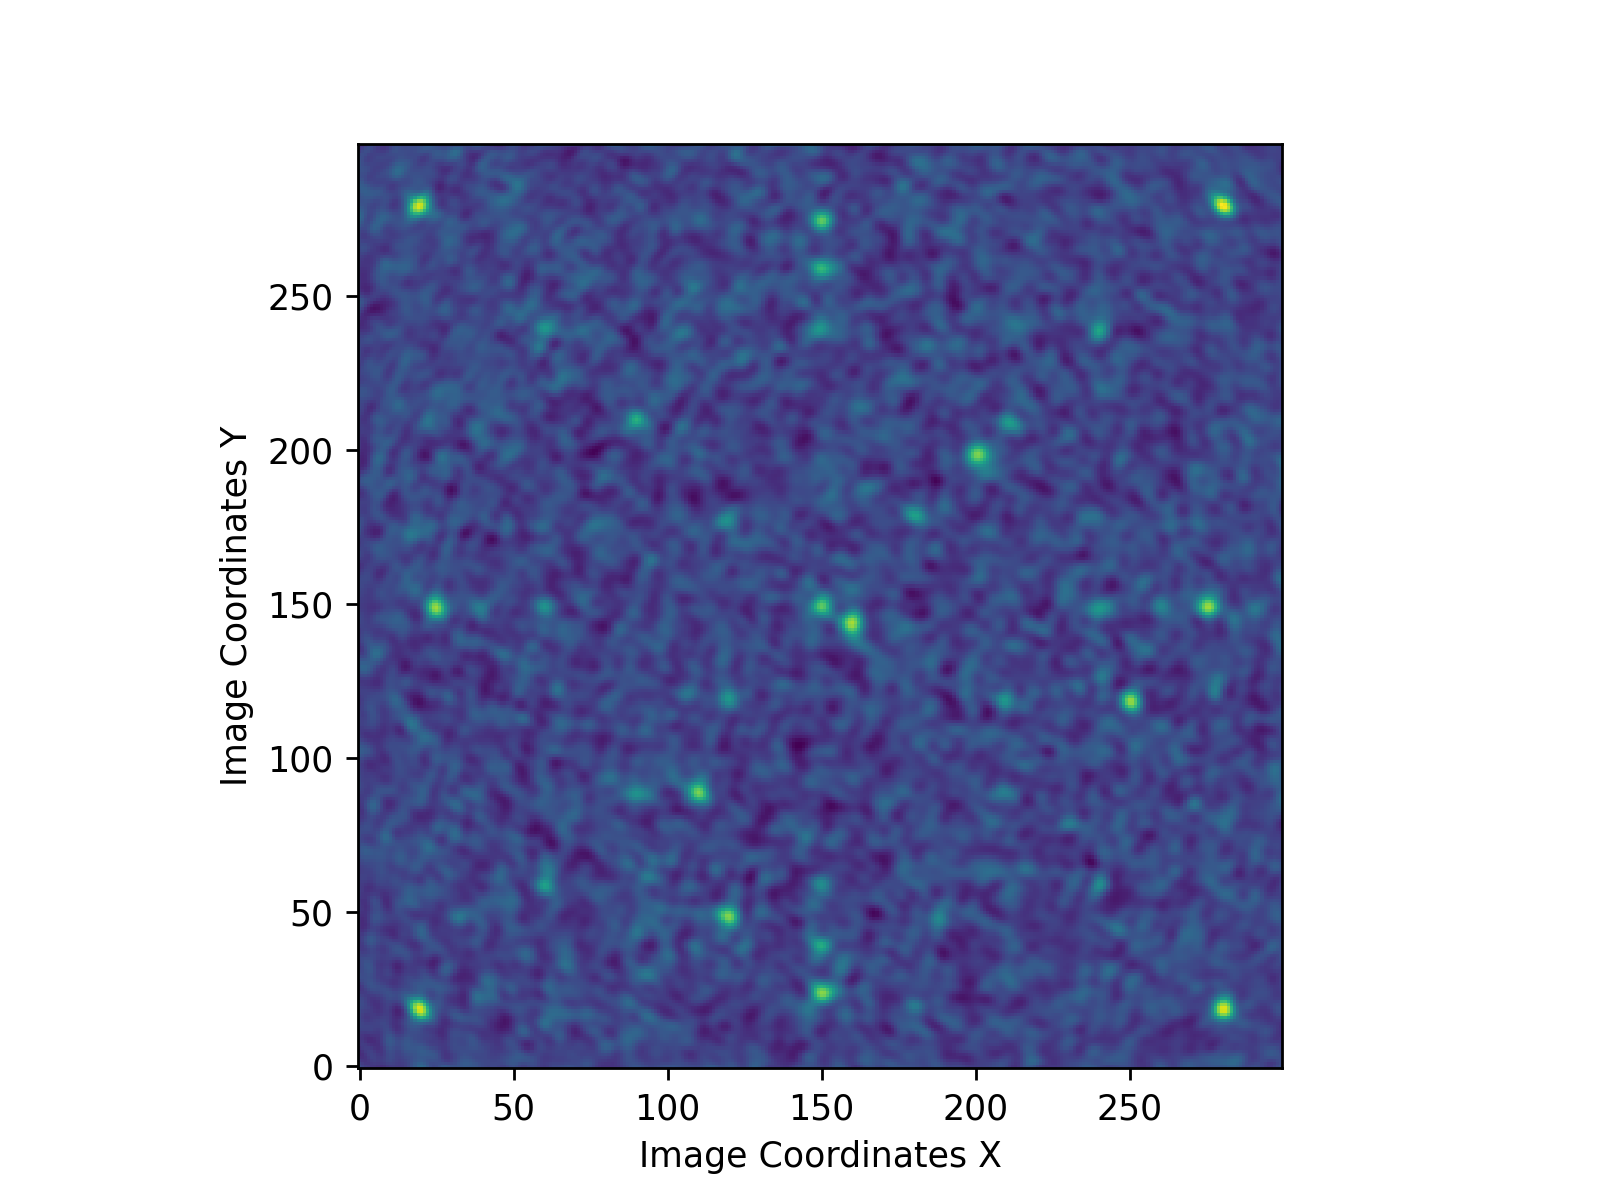

<IPython.core.display.Javascript object>


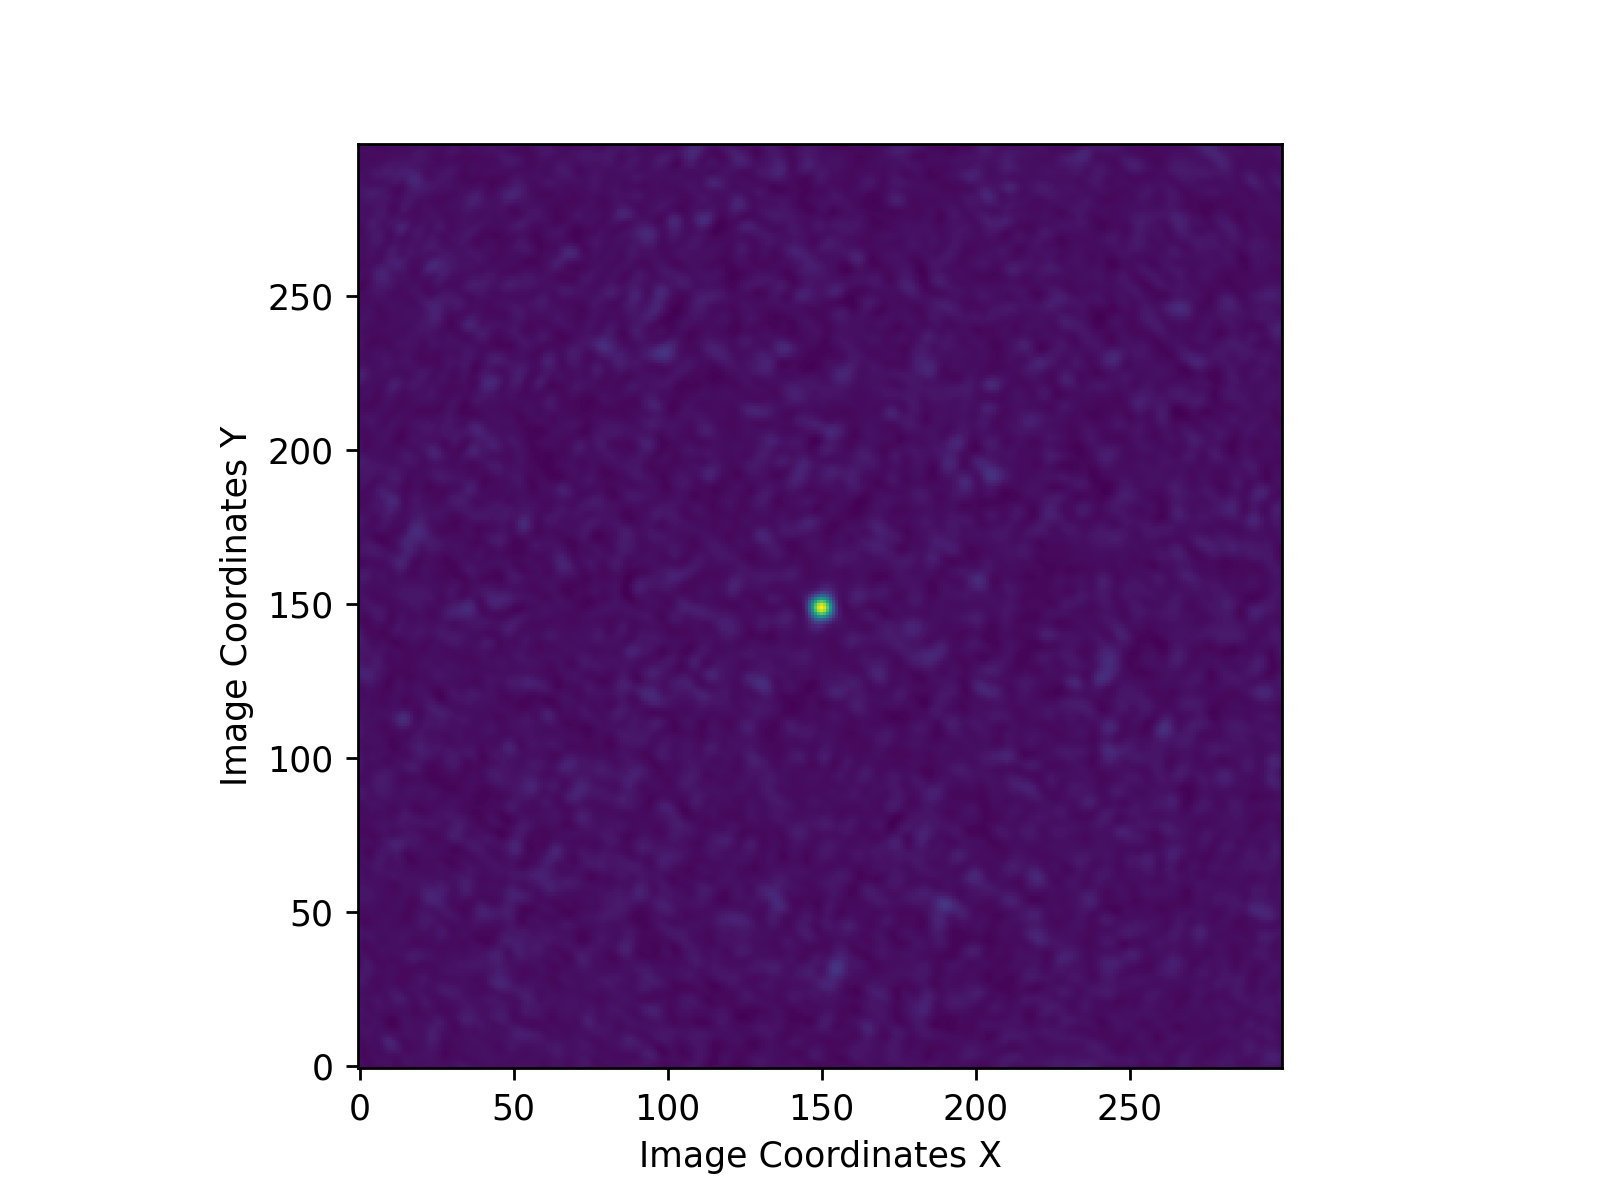

(0.3604455589839785+0j)

In [112]:
plt.figure()
plt.imshow(np.rot90(I_image_sum_corrected.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()
plt.figure()
plt.imshow(np.rot90(B_image_sum_corrected.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
#plt.savefig('Zfaceting_DFT.png', bbox_inches = 'tight')
plt.show()
B_image_sum_corrected[150,150]

#### Correcting function on z axis

In [69]:
def int5(h_x, iz, zin, step):
    y0=h_x[iz]
    y1=h_x[iz+step]
    ym1=h_x[iz-step]
    y2=h_x[iz+2*step]
    y3=h_x[iz+3*step]
    ym2=h_x[iz-2*step]
    a0=y0
    if((zin<0.) or (zin>1.)):
        print("This should not happen\n.")
    else:
        a1 = y1-(1./3)*y0-(1./2)*ym1+(1./20)*ym2-(1./4)*y2+(1./30)*y3
        a2 = (2./3)*ym1-(5./4)*y0+(2./3)*y1-(1./24)*ym2-(1./24)*y2
        a3 = (7./24)*y2+(5./12)*y0-(7./12)*y1-(1./24)*ym2-(1./24)*ym1-(1./24)*y3
        a4 = (1./24)*ym2+(1./4)*y0-(1./6)*y1-(1./6)*ym1+(1./24)*y2
        a5 = (1./120)*y3-(1./12)*y0+(1./12)*y1+(1./24)*ym1-(1./24)*y2-(1./120)*ym2 
        ans = a0 + a1*zin + a2*zin*zin + a3*zin*zin*zin + a4*zin*zin*zin*zin +a5*zin*zin*zin*zin*zin
    return ans



In [70]:
yrange = Y_max - Y_min
xrange = X_max - X_min
ny = 600
nx = 600
dw = w_values[1] - w_values[0]
fmap = np.zeros((nx,ny))
for i in range(ny):
    yy = 2.*yrange*(i - ny/2)/ny
    for j in range(nx):
        xx = 2.*xrange*(j - nx/2)/nx
        if (xx*xx + yy*yy > 0.99999999) or (abs(xx) > 0.55*xrange) or (abs(yy) > 0.55*yrange):
            z = 0.
        else:
            z = dw*(1. - np.sqrt(1. - xx*xx - yy*yy))
            ind0 = (int)(z*nx + nx/2.)
            #print (z, ind0)
            xin = (float) (z*nx + nx/2.) - ind0
            fmap[i,j] = int5(h_map4,ind0,xin,1)

<IPython.core.display.Javascript object>


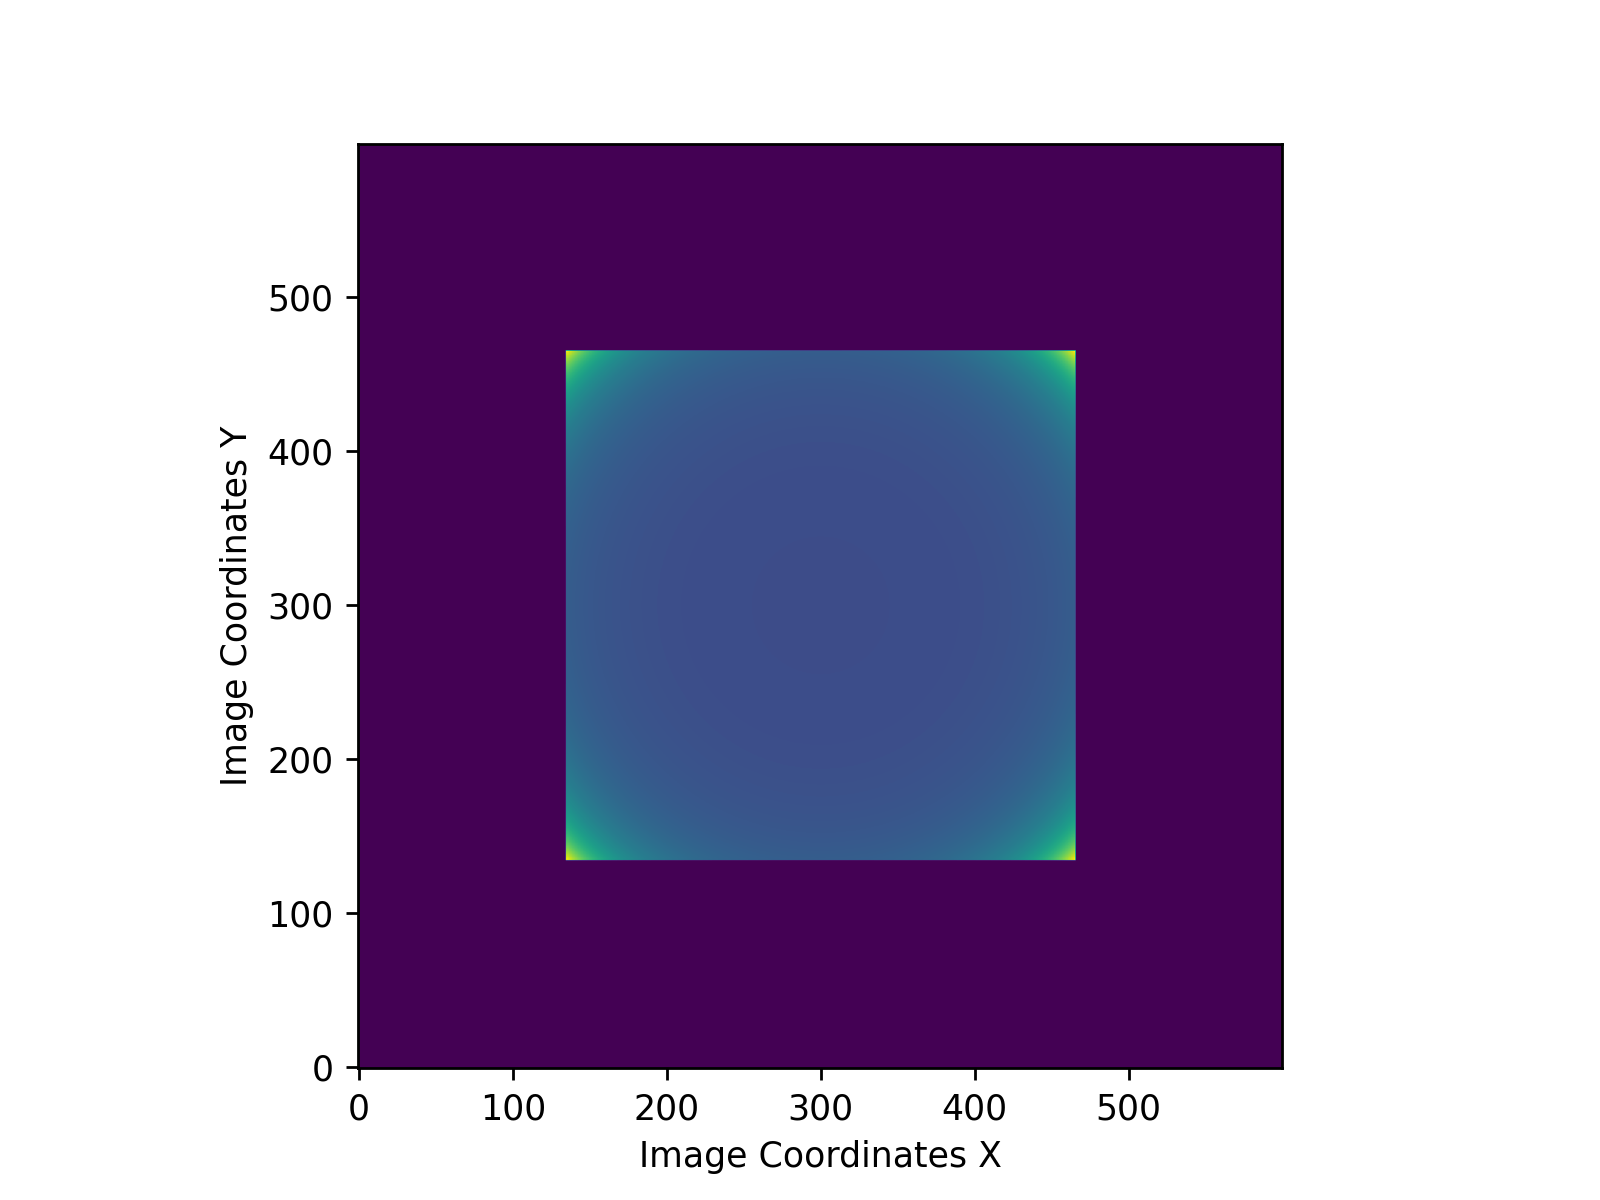

0.9999999706963939

In [71]:
plt.figure()
plt.imshow(fmap, origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
#plt.savefig('Zfaceting_DFT.png', bbox_inches = 'tight')
plt.show()
fmap[300,300]

In [72]:
temp = np.delete(fmap,np.s_[0:I_size//2],0)
temp = np.delete(temp,np.s_[I_size:index_x],0)
temp = np.delete(temp,np.s_[0:I_size//2],1)
Cor_gridz = np.delete(temp,np.s_[I_size:index_y],1)

<IPython.core.display.Javascript object>


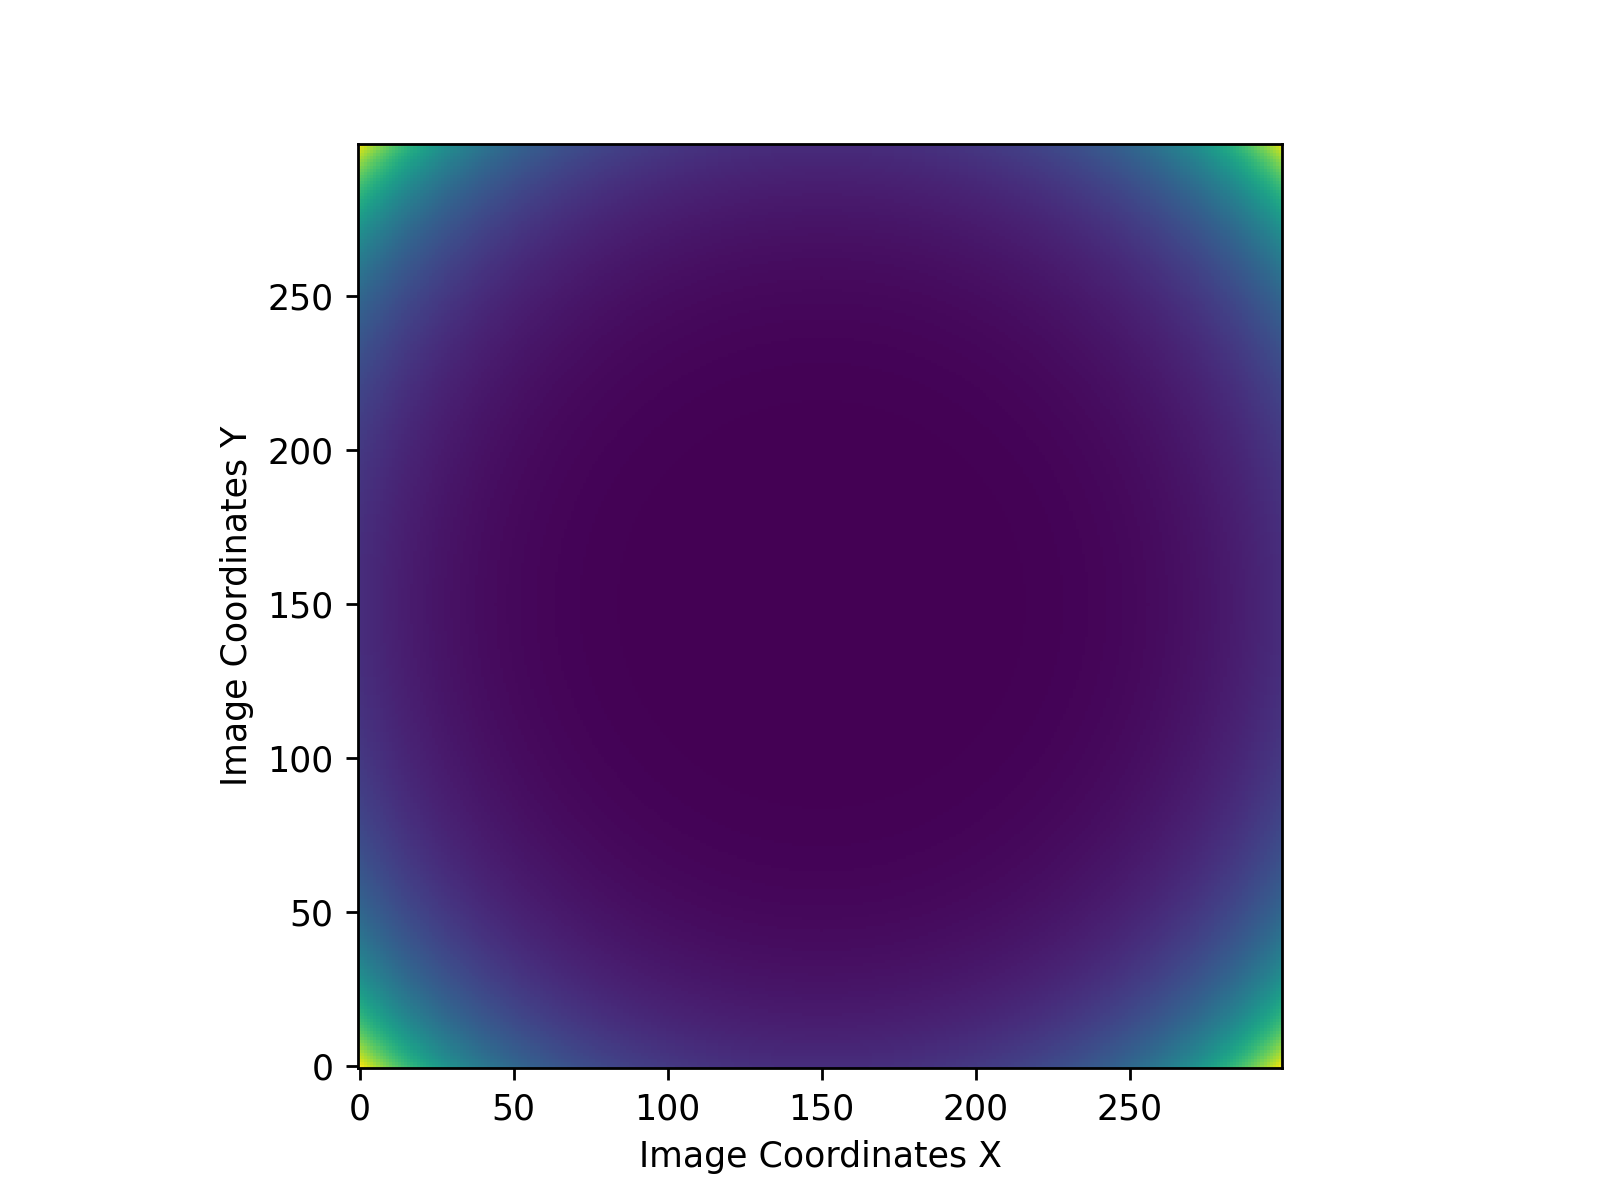

0.9999999706963939

In [73]:
plt.figure()
plt.imshow(Cor_gridz, origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
#plt.savefig('Zfaceting_DFT.png', bbox_inches = 'tight')
plt.show()
Cor_gridz[150,150]

In [74]:
I_image_sum_zcorrected = np.zeros([I_size,I_size],dtype = np.complex_)
B_image_sum_zcorrected = np.zeros([I_size,I_size],dtype = np.complex_)

for i in range(0,I_size):
    for j in range(0,I_size):
        B_image_sum_zcorrected[i,j] = B_image_sum_corrected[i,j] * Cor_gridz[i,j]

for i in range(0,I_size):
    for j in range(0,I_size):
        I_image_sum_zcorrected[i,j] = I_image_sum_corrected[i,j] * Cor_gridz[i,j]


<IPython.core.display.Javascript object>


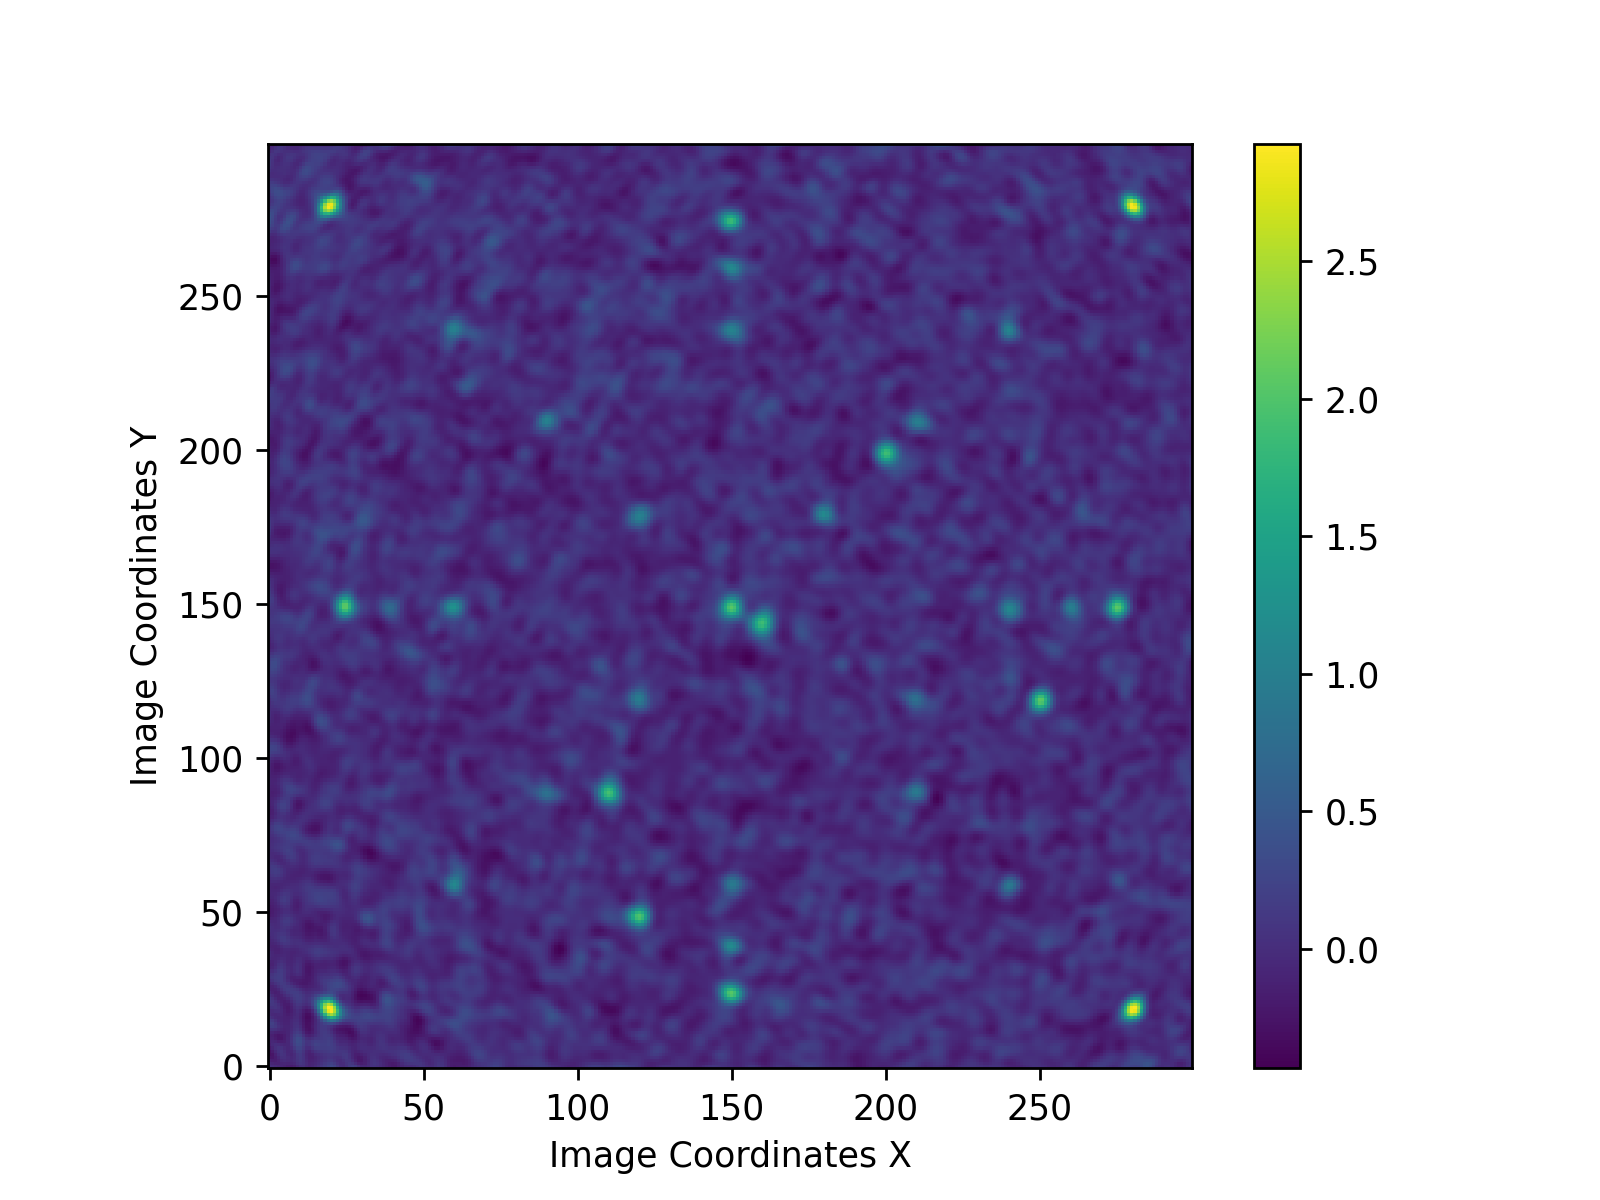

(0.9999999217322699+0j)

In [75]:
plt.figure()
plt.imshow(np.rot90(I_image_sum_zcorrected.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.colorbar()
#plt.savefig('Wstacking_63.png', bbox_inches = 'tight')
plt.show()
B_image_sum_zcorrected[150,150]

In [135]:
I_image_sum_zcorrected.real

array([[-0.1000600199153629, -0.1132893893334333, -0.0514548569216554,
        ..., -0.1356330046356972, -0.0445048989280011,
         0.0064600343609267],
       [-0.0781804977551575, -0.0370712923349094,  0.0395248557261062,
        ..., -0.1639059395507015, -0.0786879656700999,
        -0.0105968484788868],
       [-0.0149095666851419,  0.0561844372626939,  0.0973632327505293,
        ..., -0.1571229257961568, -0.1058955326538337,
        -0.0344296359449547],
       ...,
       [-0.0002069484446154,  0.0066829081964082, -0.0076770636429282,
        ..., -0.0169310534068242, -0.0831455429370537,
        -0.0654392409006028],
       [-0.0180566271498168, -0.0156300751131927, -0.0280368034409521,
        ...,  0.0439112267869461,  0.002851791803587 ,
         0.020979481700135 ],
       [-0.0410565885048001, -0.0362066011635083, -0.0401889338503106,
        ...,  0.0850374924896158,  0.0556164870881647,
         0.0665415155447001]])

In [ ]:
I_image_